Epoch 20, Loss = 8.2427
Epoch 40, Loss = 11.3652
Epoch 40, Loss = 11.3652
Epoch 60, Loss = 5.4155
Epoch 60, Loss = 5.4155
Epoch 80, Loss = 3.8689
Epoch 80, Loss = 3.8689
Epoch 100, Loss = 4.6197
Epoch 100, Loss = 4.6197
Epoch 120, Loss = 8.7283
Epoch 120, Loss = 8.7283
Epoch 140, Loss = 2.2218
Epoch 140, Loss = 2.2218
Epoch 160, Loss = 5.3568
Epoch 160, Loss = 5.3568
Epoch 180, Loss = 7.2875
Epoch 180, Loss = 7.2875
Epoch 200, Loss = 5.3174
Epoch 200, Loss = 5.3174
Epoch 220, Loss = 2.8309
Epoch 220, Loss = 2.8309
Epoch 240, Loss = 5.9491
Epoch 240, Loss = 5.9491
Epoch 260, Loss = 5.7759
Epoch 260, Loss = 5.7759
Epoch 280, Loss = 8.4390
Epoch 280, Loss = 8.4390
Epoch 300, Loss = 2.8448
✅ Training done. Model saved as text2num.pth
Epoch 300, Loss = 2.8448
✅ Training done. Model saved as text2num.pth


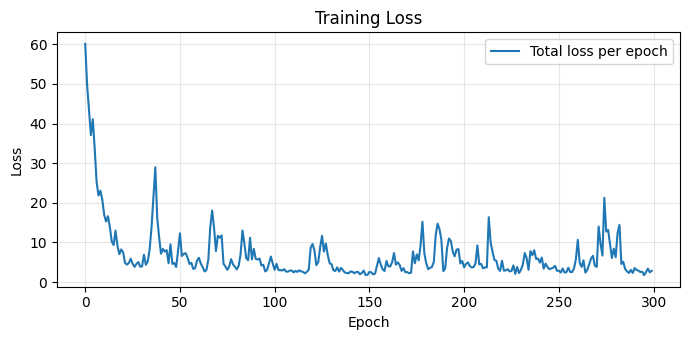

một nghìn hai trăm ba mươi bốn → 1234
năm nghìn sáu trăm bảy mươi tám → 5678
mười một → 1
một trăm lẻ một → 101


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import random

# -----------------------------
# 1. DỮ LIỆU HUẤN LUYỆN
# -----------------------------

# Special tokens
PAD_WORD = "<pad_w>"
SOS_WORD = "<sos_w>"
EOS_WORD = "<eos_w>"

PAD_NUM = "<pad_n>"
SOS_NUM = "<sos_n>"
EOS_NUM = "<eos_n>"

numbers = {
    "0": ["không"],
    "1": ["một"],
    "2": ["hai"],
    "3": ["ba"],
    "4": ["bốn"],
    "5": ["năm"],
    "6": ["sáu"],
    "7": ["bảy"],
    "8": ["tám"],
    "9": ["chín"],
    "10": ["mười"],
    "11": ["mười một"],
    "12": ["mười hai"],
    "13": ["mười ba"],
    "14": ["mười bốn"],
    "15": ["mười lăm"],
    "20": ["hai mươi"],
    "30": ["ba mươi"],
    "40": ["bốn mươi"],
    "50": ["năm mươi"],
    "100": ["một trăm"],
    "101": ["một trăm lẻ một"],
    "110": ["một trăm mười"],
    "115": ["một trăm mười lăm"],
    "1234": ["một nghìn hai trăm ba mươi bốn"],
    "5678": ["năm nghìn sáu trăm bảy mươi tám"],
    "9001": ["chín nghìn không trăm lẻ một"]
}

# tạo tập dữ liệu
dataset = []
for num, words in numbers.items():
    word_list = words[0].split()
    src = word_list        # đầu vào là chữ
    tgt = list(num)        # đầu ra là chuỗi số
    dataset.append((src, tgt))


# -----------------------------
# 2. TẠO VOCAB
# -----------------------------

# vocab chữ
word_vocab = {PAD_WORD: 0, SOS_WORD: 1, EOS_WORD: 2}
for _, words in numbers.items():
    for w in words[0].split():
        if w not in word_vocab:
            word_vocab[w] = len(word_vocab)

# vocab số
num_vocab = {PAD_NUM: 0, SOS_NUM: 1, EOS_NUM: 2}
for num in numbers.keys():
    for ch in num:
        if ch not in num_vocab:
            num_vocab[ch] = len(num_vocab)

inv_num_vocab = {v: k for k, v in num_vocab.items()}
inv_word_vocab = {v: k for k, v in word_vocab.items()}


# -----------------------------
# 3. TẬP DỮ LIỆU TENSOR
# -----------------------------
class TextToNumberDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]

        src_idx = [word_vocab[SOS_WORD]] + [word_vocab[w] for w in src] + [word_vocab[EOS_WORD]]
        tgt_idx = [num_vocab[SOS_NUM]] + [num_vocab[ch] for ch in tgt] + [num_vocab[EOS_NUM]]

        return torch.LongTensor(src_idx), torch.LongTensor(tgt_idx)


# -----------------------------
# 4. TRANSFORMER MODEL
# -----------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (T, N, E)
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=128, nhead=8, num_layers=2):
        super().__init__()
        self.src_embed = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_enc_src = PositionalEncoding(d_model)
        self.pos_enc_tgt = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_layers, num_layers)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.d_model = d_model

    def _generate_square_subsequent_mask(self, sz: int, device):
        mask = torch.full((sz, sz), float('-inf'), device=device)
        mask = torch.triu(mask, diagonal=1)
        return mask

    def forward(self, src, tgt):
        # src, tgt: (N, T)
        src_emb = self.src_embed(src) * math.sqrt(self.d_model)
        tgt_emb = self.tgt_embed(tgt) * math.sqrt(self.d_model)

        # Transformer expects (T, N, E)
        src_emb = src_emb.transpose(0, 1)
        tgt_emb = tgt_emb.transpose(0, 1)

        # add positional encodings
        src_emb = self.pos_enc_src(src_emb)
        tgt_emb = self.pos_enc_tgt(tgt_emb)

        tgt_mask = self._generate_square_subsequent_mask(tgt_emb.size(0), tgt_emb.device)

        output = self.transformer(src_emb, tgt_emb, tgt_mask=tgt_mask)
        output = self.fc_out(output)
        return output.transpose(0, 1)


# -----------------------------
# 5. HÀM HUẤN LUYỆN
# -----------------------------
def train_model(epochs: int = 300):
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    model = Transformer(len(word_vocab), len(num_vocab))
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    criterion = nn.CrossEntropyLoss(ignore_index=num_vocab[PAD_NUM])

    loader = torch.utils.data.DataLoader(TextToNumberDataset(dataset), batch_size=1, shuffle=True)

    epoch_losses = []
    for epoch in range(epochs):
        total_loss = 0.0
        for src, tgt in loader:
            optimizer.zero_grad()
            output = model(src, tgt[:, :-1])  # predict next token
            loss = criterion(output.reshape(-1, output.size(-1)), tgt[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        epoch_losses.append(total_loss)
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}, Loss = {total_loss:.4f}")

    torch.save(model.state_dict(), "text2num.pth")
    print("✅ Training done. Model saved as text2num.pth")
    return model, epoch_losses


# -----------------------------
# 6. HÀM DỰ ĐOÁN
# -----------------------------
def predict(model, sentence: str, max_len: int = 16):
    model.eval()
    words = sentence.strip().split()
    for w in words:
        if w not in word_vocab:
            raise ValueError(f"Từ không có trong từ điển huấn luyện: '{w}'")

    src = torch.LongTensor([[word_vocab[SOS_WORD]] + [word_vocab[w] for w in words] + [word_vocab[EOS_WORD]]])
    tgt = torch.LongTensor([[num_vocab[SOS_NUM]]])

    with torch.no_grad():
        for _ in range(max_len):
            output = model(src, tgt)               # (1, T, V)
            next_token = output[0, -1].argmax().item()
            if next_token == num_vocab[EOS_NUM]:   # stop at EOS
                break
            tgt = torch.cat([tgt, torch.LongTensor([[next_token]])], dim=1)

    # Decode tokens after SOS, before EOS
    decoded = []
    for idx in tgt[0][1:]:
        tok = inv_num_vocab[idx.item()]
        if tok in (PAD_NUM, EOS_NUM, SOS_NUM):
            break
        decoded.append(tok)
    return "".join(decoded)


# -----------------------------
# 7. CHẠY DEMO
# -----------------------------
if __name__ == "__main__":
    model, losses = train_model()

    # Vẽ biểu đồ loss
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(7, 3.5))
        plt.plot(losses, label='Total loss per epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Không thể vẽ biểu đồ loss:", e)

    tests = [
        "một nghìn hai trăm ba mươi bốn",
        "năm nghìn sáu trăm bảy mươi tám",
        "mười một",
        "một trăm lẻ một"
    ]

    for t in tests:
        print(f"{t} → {predict(model, t)}")
